In [1]:
import csv
import os
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import time
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [2]:
import itertools

# Removed "Manufacturing"
DOMAIN_TO_KAGGLE_TAGS = {
    # 'Manufacturing': ['Manufacturing'],
    'Automotive': ['Automobiles and Vehicles'],
    'Gaming': ['Games', 'Video Games'],
    'Healthcare': ['Biology', 'Healthcare', 'Health', 'Medicine'],
    'Retail & Marketing': ['Retail and Shopping', 'Travel'],
    'Resources': ['Earth and Nature', 'Earth Science', 'Atmospheric Science', 'Oil and Gas', 'Water Bodies', 'Energy', 'Electricity', 'Geology'],
    'Media & Entertainment': ['News', 'Social Networks', 'Arts and Entertainment'],
    'Financial': ['Finance', 'Economics', 'Investing', 'Insurance'],
    'Other': ['Demographics', 'Housing', 'Social Science', 'Education']
}
DOMAINS = list(DOMAIN_TO_KAGGLE_TAGS.keys())

TAGS = list(itertools.chain.from_iterable(DOMAIN_TO_KAGGLE_TAGS.values()))
# api.dataset_download_files
# for domain in DOMAINS:
#     tags = DOMAIN_TO_KAGGLE_TAGS[domain]
#     api.dataset_list_cli(tag_ids=tags, sort_by='votes', file_type='csv', max_size=10**7, csv_display=False) # TODO: add max_size (bytes)

# 1. Grab Datasets from Kaggle API

In [4]:
tag_to_dataset_count = {}
for tag in TAGS:
    tag_to_dataset_count[tag] = 0

### 1.1 Select datasets by tags with 'csv' filter

In [4]:
# def get_tag_info_from_first_page(tag_id: str):
#     # Get datasets on first page (sorted by votes)
#     datasets = api.dataset_list(tag_ids=tag_id, sort_by='votes')
#     for dataset in datasets:
#         for tag_obj in dataset.tags:
#             if tag_obj.nameNullable == tag_id.lower() or tag_obj.ref == tag_id.lower():
#                 return [tag_obj.ref, tag_obj.fullPath, tag_obj.datasetCount]
#     return []

Extract and save all selected tags info to csv file `tags.csv`.

In [5]:
# TAGS_FIELDS = ['ref', 'fullPath', 'datasetCount']

# with open('tags.csv', 'w') as tags_file:
#     # Write fields on first row of CSV file
#     writer_tags = csv.writer(tags_file, delimiter=',')
#     for domain in DOMAINS:
#         for tag_id in DOMAIN_TO_KAGGLE_TAGS[domain]:
#             tag_info_list = get_tag_info_from_first_page(tag_id)
#             if len(tag_info_list):
#                 writer_tags.writerow(tag_info_list)
#             else:
#                 raise Exception("Tag info not found on first page for tag_id=" + str(tag_id))

Create list of datasets that contain the selected tags. Write to CSV file 'datasets.csv'.

In [5]:
DATASETS_FIELDS = ['index', 'ref', 'voteCount', 'usabilityRatingNullable', 'downloadCount', 'totalBytesNullable', 'lastUpdated', 'tags', 'used_tag']

In [7]:
# def write_all_datasets_info_for_tags(tag_ids: list[str], filename: str='datasets'):
#     DATASETS_FIELDS = ['index', 'ref', 'voteCount', 'usabilityRatingNullable', 'downloadCount', 'totalBytesNullable', 'lastUpdated', 'tags', 'used_tag']
#     print("Grabbing dataset info from Kaggle API...")
#     print("- %d Tags: " + str(tag_ids))
#     print("\n")
#     n_datasets_total = 0
#     start_time = time.time()
#     with open(filename + '.csv', 'w') as datasets_file:
#         writer_datasets = csv.writer(datasets_file, delimiter=',')
#         # Write fields on first row of CSV file
#         writer_datasets.writerow(DATASETS_FIELDS)
#         for i, tag_id in enumerate(TAGS):
#             page = 1
#             n_datasets_per_tag = 0
#             while True: # Pagination
#                 datasets = api.dataset_list(tag_ids=tag_id, sort_by='votes', file_type='csv', max_size=10**7, page=page)
#                 n_datasets_per_tag += len(datasets)
#                 page += 1
#                 if len(datasets) > 0:
#                     # Read all datasets from page
#                     for i, ds in enumerate(datasets):
#                         writer_datasets.writerow([i, ds.ref, ds.voteCount, ds.usabilityRatingNullable, ds.downloadCount, 
#                                                 ds.totalBytesNullable, ds.lastUpdated, ds.tags, tag_id])   
#                 else:
#                     # Encountered empty page (no more datasets)
#                     print("%d/%d Found %d datasets (%d pages) for tag_id=%s" % (i + 1, len(tag_ids), n_datasets_per_tag, page, tag_id))
#                     n_datasets_total += n_datasets_per_tag
#                     break
#     end_time = time.time()
#     print("Took %f s. Found %d datasets in total" % (end_time - start_time, n_datasets_total))

### 1.2 Augment with high value datasets

In [8]:
df = pl.read_csv('datasets_2.csv', has_header=True)
df = df.unique(subset='ref', maintain_order=True)
df = df.rename({'used_tag\r': 'used_tag'})

In [9]:
len(df)

21732

In [10]:
len(df.filter(pl.col('downloadCount') >= 100))

9348

In [11]:
len(df.filter(pl.col('voteCount') >= 50))

1265

In [12]:
def write_high_value_datasets(filename: str='datasets_high_value', n_datasets: int=500):
    n_datasets_total = 0
    DATASETS_FIELDS = ['index', 'ref', 'voteCount', 'usabilityRatingNullable', 'downloadCount', 'totalBytesNullable', 'lastUpdated', 'tags']
    start_time = time.time()
    with open(filename + '.csv', 'w') as datasets_file:
        writer_datasets = csv.writer(datasets_file, delimiter=',')
        # Write fields on first row of CSV file
        writer_datasets.writerow(DATASETS_FIELDS)
        page = 1
        while page < n_datasets // 20: # Pagination
            datasets = api.dataset_list(sort_by='votes', page=page)
            page += 1
            n_datasets_total += len(datasets)
            if len(datasets) > 0:
                # Read all datasets from page
                for i, ds in enumerate(datasets):
                    writer_datasets.writerow([i, ds.ref, ds.voteCount, ds.usabilityRatingNullable, ds.downloadCount, 
                                            ds.totalBytesNullable, ds.lastUpdated, ds.tags])   
    end_time = time.time()
    print("Took %f s. Found %d high-valued datasets in total" % (end_time - start_time, n_datasets_total))

In [13]:
# write_high_value_datasets('test_hv.csv', n_datasets=1000)

In [14]:
# Two files for high value datasets: 'datasets_high_value_1000.csv' & 'datasets_high_value_10000.csv'
df_hv = pl.read_csv('datasets_high_value_10000.csv', has_header=True)
df_hv = df_hv.unique(subset='ref', maintain_order=True)
df_hv = df_hv.with_columns([pl.lit('').alias('used_tag')])
df_hv = df_hv.rename({'tags\r': 'tags'})

Check which of these high value datasets were not already selected before.

In [15]:
df_hv = df_hv.filter(~pl.col('ref').is_in(df['ref'].to_list()))
len(df_hv)

5845

Filter out image datasets.

In [16]:
image_tags = ['computer vision', 'vision', 'image'] 
regex = '|'.join(image_tags)
df_hv = df_hv.filter(~pl.col('tags').str.contains(regex))
len(df_hv)

4873

Filter out hv datasets with less than 100 downloads.

In [17]:
df_hv = df_hv.filter(pl.col('downloadCount') >= 100)
len(df_hv)

4437

Filter datasets with less than 50 upvotes.

In [18]:
df_hv = df_hv.filter(pl.col('voteCount') >= 50)
len(df_hv)

1769

Combine the two dataframes into one.

In [19]:
df_combined = pl.concat([df, df_hv], rechunk=True)

In [20]:
len(df_combined)

23501

Remove datasets with less than 100 downloads.

In [21]:
df_combined = df_combined.filter(pl.col('downloadCount') >= 100)

In [22]:
print('We are left with %d datasets to sample' % len(df_combined))

We are left with 11117 datasets to sample


Add `ref_no_slash` column.

In [24]:
df_combined = df_combined.with_columns([(pl.col('ref').str.replace('/', '_')).alias('ref_no_slash')])

# 2. Analyze Distribution of Upvotes, Downloads and Usability

In [25]:
print("Votes:             min=%.2f, avg=%.2f, mode=%.2f, max=%.2f, skew=%.2f, kurt=%.2f" % (df_combined['voteCount'].min(), 
                                                                      df_combined['voteCount'].mean(), 
                                                                      df_combined['voteCount'].median(), 
                                                                      df_combined['voteCount'].max(),
                                                                      df_combined['voteCount'].skew(),
                                                                      df_combined['voteCount'].kurtosis()
                                                                      ))
print("Usability Rating:  min=%.2f, avg=%.2f, mode=%.2f, max=%.2f, skew=%.2f, kurt=%.2f" % (df_combined['usabilityRatingNullable'].min(), 
                                                                      df_combined['usabilityRatingNullable'].mean(), 
                                                                      df_combined['usabilityRatingNullable'].median(), 
                                                                      df_combined['usabilityRatingNullable'].max(),
                                                                      df_combined['usabilityRatingNullable'].skew(),
                                                                      df_combined['usabilityRatingNullable'].kurtosis()
                                                                      ))
print("Donwloads:         min=%.2f, avg=%.2f, mode=%.2f, max=%.2f, skew=%.2f, kurt=%.2f" % (df_combined['downloadCount'].min(), 
                                                                      df_combined['downloadCount'].mean(), 
                                                                      df_combined['downloadCount'].median(), 
                                                                      df_combined['downloadCount'].max(),
                                                                      df_combined['downloadCount'].skew(),
                                                                      df_combined['downloadCount'].kurtosis()
                                                                      ))

Votes:             min=0.00, avg=72.38, mode=21.00, max=29520.00, skew=44.42, kurt=3004.39
Usability Rating:  min=0.00, avg=0.80, mode=0.88, max=1.00, skew=-1.00, kurt=0.06
Donwloads:         min=100.00, avg=3562.72, mode=528.00, max=505998.00, skew=14.96, kurt=317.35


Analyze distributions.

In [26]:
col_names = ['voteCount', 'usabilityRatingNullable', 'downloadCount']
maxs = [df_combined['voteCount'].max(), df_combined['usabilityRatingNullable'].max(), df_combined['downloadCount'].max()]
bin_widths = [50, 0.1, 200]

probs = []

for i, col_name in enumerate(col_names):
    bin_width = bin_widths[i]
    counts = []
    for low in np.arange(0, maxs[i] + bin_width, bin_width):
        high = low + bin_width
        # print("[%.2f, %.2f]" % (low, high))
        counts.append(len(df_combined.filter((pl.col(col_name) >= low) & (pl.col(col_name) < high))))
    probs.append(np.array(counts) / len(df_combined))

probs_dict = {'voteCount': probs[0], 'usabilityRating': probs[1], 'downloadCount': probs[2]}

In [27]:
print(probs_dict['voteCount'][0])
print(probs_dict['downloadCount'][0])

0.7282540253665557
0.22964828640820364


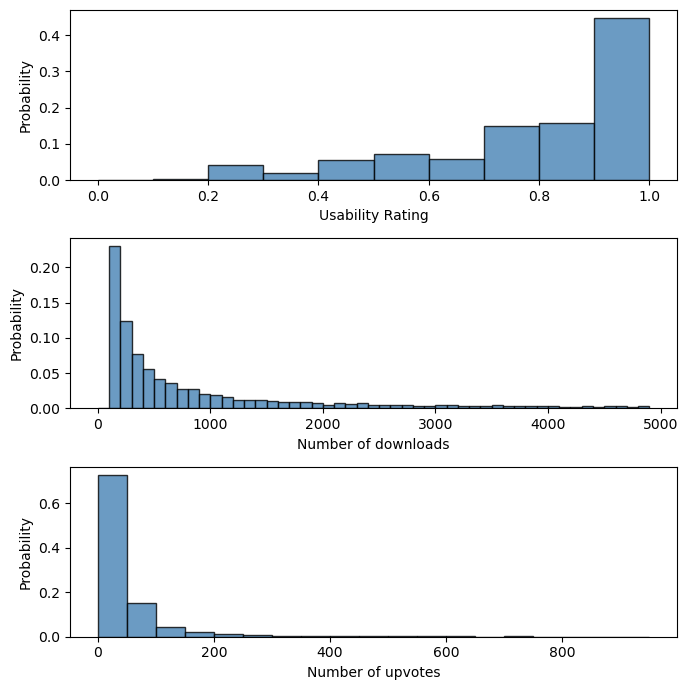

In [28]:
fig, axs = plt.subplots(3, figsize=(7, 7)) 

usability = df_combined['usabilityRatingNullable']
weights = np.ones_like(usability) / (len(usability))
axs[0].hist(usability, bins=np.arange(0, usability.max() + 0.1, 0.1), weights=weights, alpha=0.8, color='steelblue', edgecolor='black')
axs[0].set(ylabel='Probability', xlabel='Usability Rating')

downloads = df_combined['downloadCount']
weights = np.ones_like(downloads) / (len(downloads))
axs[1].hist(downloads, bins=np.arange(0, 5000, 100), weights=weights, alpha=0.8, color='steelblue', edgecolor='black')
axs[1].set(ylabel='Probability', xlabel='Number of downloads')


votes = df_combined['voteCount']
weights = np.ones_like(votes) / (len(votes))
axs[2].hist(votes, bins=np.arange(0, 1000, 50), weights=weights, alpha=0.8, color='steelblue', edgecolor='black')
axs[2].set(ylabel='Probability', xlabel='Number of upvotes')

plt.tight_layout()
plt.savefig('distribution_upvotes_downloads_usability.png', dpi=300)
plt.show()

# 3. Create Proxy Metric

Replace null values for `usabilityRatingNullable` with 0.1 (value less than min 0.11). Then, rename `usabilityRatingNullable` to `usabilityRating`.

In [29]:
df_combined['usabilityRatingNullable'].min()

0.0

Replace NaN with 0 for `usabilityRatingNullable` column. Rename it to `usabilityRating`.

In [30]:
df_combined = df_combined.with_columns(pl.col('usabilityRatingNullable').fill_null(pl.lit(0)).keep_name())
df_combined = df_combined.rename({'usabilityRatingNullable': 'usabilityRating'})

assert len(df_combined.filter(pl.col('usabilityRating').is_null())) == 0

In [31]:
df_combined.columns

['index',
 'ref',
 'voteCount',
 'usabilityRating',
 'downloadCount',
 'totalBytesNullable',
 'lastUpdated',
 'tags',
 'used_tag',
 'ref_no_slash']

In [32]:
df_combined = df_combined.filter(pl.col('ref') != 'jessicali9530/animal-crossing-new-horizons-nookplaza-dataset')
len(df_combined)

11116

## Create Proxy

$proxy = \beta_1 \ \# upvotes + \beta_2 \ \# downloads + \beta_3 \ \# usability + \beta_4 \ \max(1, \frac{\# upvotes}{\# downloads})$ where $\beta_i \geq 0$.

We then normalize $proxy$ to be in $[0, 100]$.

Normalize votes, usability rating and download count.

Choose importance coefficients and multiply the target columns with them.

In [33]:
def create_proxy_values(data, coeffs):
    votes_coeff = coeffs[0]
    downloads_coeff = coeffs[1]
    usability_coeff = coeffs[2]
    fraction_coeff = coeffs[3]
    
    # Cap voteCount to the number to dowloadCount
    voteCount_capped = np.minimum(data['voteCount'], data['downloadCount'])
    voteCount_capped_min = voteCount_capped.min()
    voteCount_capped_max = voteCount_capped.max()
    # Normalize voteCount column in [0, 100]
    voteCount_capped_normalized = (voteCount_capped - voteCount_capped_min) / (voteCount_capped_max - voteCount_capped_min) * 100

    # Normalize downloadCount column in [0, 100]
    downloadCount_min = data['downloadCount'].min()
    downloadCount_max = data['downloadCount'].max()
    downloadCount_normalized = (data['downloadCount'] - downloadCount_min) / (downloadCount_max - downloadCount_min) * 100
    
    # Usability rating coumn already in [0, 1]
    usabilityRating_normalized = df_combined['usabilityRating'] * 100

    # Create voteCount / downloadCount column
    downloadCount_non_zero = np.maximum(1, data['downloadCount'].to_numpy())
    votesToDownloads = np.minimum(1, df_combined['voteCount'].to_numpy() / downloadCount_non_zero)
    votesToDownloads_normalized = (votesToDownloads - votesToDownloads.min()) / (votesToDownloads.max() - votesToDownloads.min()) * 1000


    # Multiply by given importance coefficients
    voteCount_capped_multiplied = voteCount_capped_normalized * votes_coeff
    downloadCount_multiplied = downloadCount_normalized * downloads_coeff
    usabilityRating_multiplied = usabilityRating_normalized * usability_coeff
    votesToDownloads_multiplied = votesToDownloads_normalized * fraction_coeff

    proxy = voteCount_capped_multiplied + downloadCount_multiplied + usabilityRating_multiplied + votesToDownloads_multiplied
    proxy_normalized = (proxy - proxy.min()) / (proxy.max() - proxy.min()) * 100

    return proxy_normalized

In [34]:
from itertools import product

coeff_values = np.arange(0, 1.1, 0.2)

coeffs_list = []
iqr_list = []
for coeffs in product(coeff_values, coeff_values, coeff_values, coeff_values):
    proxy = create_proxy_values(df_combined, list(coeffs))
    q1, q3 = np.percentile(proxy, [25, 75])
    iqr = q3 - q1
    coeffs_list.append(list(coeffs))
    iqr_list.append(iqr)

df_coeffs = pl.from_dict({'iqr': iqr_list, 'coeffs': coeffs_list})
df_coeffs = df_coeffs.filter(pl.col('iqr').is_not_nan())
df_coeffs = df_coeffs.sort('iqr', descending=True)

In [35]:
df_coeffs['coeffs'].to_list()

[[0.0, 0.0, 0.2, 0.0],
 [0.0, 0.0, 0.4, 0.0],
 [0.0, 0.0, 0.6000000000000001, 0.0],
 [0.0, 0.0, 0.8, 0.0],
 [0.0, 0.0, 1.0, 0.0],
 [0.0, 0.2, 1.0, 0.0],
 [0.2, 0.0, 1.0, 0.0],
 [0.0, 0.2, 0.8, 0.0],
 [0.2, 0.0, 0.8, 0.0],
 [0.0, 0.2, 0.6000000000000001, 0.0],
 [0.2, 0.0, 0.6000000000000001, 0.0],
 [0.2, 0.2, 1.0, 0.0],
 [0.4, 0.0, 1.0, 0.0],
 [0.0, 0.4, 1.0, 0.0],
 [0.2, 0.2, 0.8, 0.0],
 [0.0, 0.2, 0.4, 0.0],
 [0.0, 0.4, 0.8, 0.0],
 [0.2, 0.0, 0.4, 0.0],
 [0.4, 0.0, 0.8, 0.0],
 [0.4, 0.2, 1.0, 0.0],
 [0.2, 0.4, 1.0, 0.0],
 [0.0, 0.6000000000000001, 1.0, 0.0],
 [0.6000000000000001, 0.0, 1.0, 0.0],
 [0.2, 0.2, 0.6000000000000001, 0.0],
 [0.0, 0.4, 0.6000000000000001, 0.0],
 [0.4, 0.0, 0.6000000000000001, 0.0],
 [0.4, 0.2, 0.8, 0.0],
 [0.2, 0.4, 0.8, 0.0],
 [0.0, 0.6000000000000001, 0.8, 0.0],
 [0.6000000000000001, 0.2, 1.0, 0.0],
 [0.6000000000000001, 0.0, 0.8, 0.0],
 [0.4, 0.4, 1.0, 0.0],
 [0.2, 0.6000000000000001, 1.0, 0.0],
 [0.0, 0.8, 1.0, 0.0],
 [0.8, 0.0, 1.0, 0.0],
 [0.8, 0.2, 1.0

In [39]:
# coeffs = df_coeffs['coeffs'][100].to_list()
# votes, downloads, usability, fraction
coeffs=[1, 0, 0.5, 0]

In [40]:
proxy = create_proxy_values(df_combined, coeffs=coeffs)
df_proxy = df_combined.with_columns(pl.Series(name='proxy', values=proxy))

Analyze dataset.

In [41]:
def plot_mean_proxy_per_tags(data, tags, figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(figsize=figsize) 
    plt.grid(axis='y')

    proxy_means_per_tag = []
    for tag_id in tags:
        proxy_means_per_tag.append(data.filter(pl.col('tags').str.contains(tag_id.lower())).select('proxy').mean()['proxy'][0])

    ax.bar(tags, proxy_means_per_tag, color='steelblue', alpha=1, edgecolor='black')
    ax.set(ylabel='Mean proxy score')

    # leg = ax.legend(loc='center', bbox_to_anchor=(0.5, -0.1), frameon=True, ncol=4)

    plt.xticks(rotation=90)
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Distribution per Tags ' + s)
    plt.tight_layout()
    return fig

def plot_proxy_distribution_hist(data, bin_width=2, figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(figsize=figsize) 

    proxy_values = data['proxy']
    weights = np.ones_like(proxy_values) / (len(proxy_values))
    ax.hist(proxy_values, bins=np.arange(0, 100 + bin_width, bin_width), weights=weights, alpha=1, color='steelblue', edgecolor='black')

    ax.set(xlabel='Proxy score', ylabel='Probability')

    fig.tight_layout()
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Distribution ' + s)
    return fig

def plot_proxy_distribution_box(data, figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(figsize=figsize) 

    proxy_values = data['proxy']
    weights = np.ones_like(proxy_values) / (len(proxy_values))
    ax.boxplot(proxy_values, labels=['ALL'])

    # ax.set(xlabel='Proxy Score', ylabel='Count')

    fig.tight_layout()
    s = '' if coeffs == None else str(coeffs)
    plt.title('Proxy Distribution ' + s)
    plt.show()

def plot_proxy_distribution_per_domain_hist(data, figsize=(8, 6), coeffs=None):
    fig, axs = plt.subplots(4, 2, figsize=figsize) 

    for i, domain in enumerate(DOMAINS):
        ax = axs[i // 2, i % 2]
        # Make tag_ids lowercase
        tag_ids = [tag_id.lower() for tag_id in DOMAIN_TO_KAGGLE_TAGS[domain]] 
        # Create regex to check if any of the tag_ids are present in the tags column
        regex = '|'.join(tag_ids)
        df_tag = data.filter(pl.col('tags').str.contains(regex))
        proxy_values = df_tag['proxy']
        weights = np.ones_like(proxy_values) / (len(proxy_values))
        ax.hist(proxy_values, bins=np.arange(0, 101, 1), weights=weights, alpha=1, color='steelblue', edgecolor='black')
        ax.set(xlabel='Proxy score', ylabel='Probability')
        ax.set_title("%s - %d datasets" % (domain, len(df_tag)))
        # ax.grid(axis='y')
        # Hide x labels and tick labels for top plots to avoid overlap
        ax.label_outer() 
    fig.tight_layout()
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Distribution per Domain ' + s)
    plt.show()

def plot_proxy_distribution_per_domain_box(data, figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(1, figsize=figsize) 

    domain_to_proxy_values = {}
    domain_to_log_proxy_values = {}
    for i, domain in enumerate(DOMAINS):
        # Make tag_ids lowercase
        tag_ids = [tag_id.lower() for tag_id in DOMAIN_TO_KAGGLE_TAGS[domain]] 
        # Create regex to check if any of the tag_ids are present in the tags column
        regex = '|'.join(tag_ids)
        df_tag = data.filter(pl.col('tags').str.contains(regex))
        proxy_values_for_tag = df_tag['proxy']
        domain_to_proxy_values[domain] = proxy_values_for_tag
        # domain_to_log_proxy_values[domain] = np.log(proxy_values_for_tag)

    plt.boxplot(x=list(domain_to_proxy_values.values()), labels=list(domain_to_proxy_values.keys()))
    ax.set(ylabel='Proxy score')
    # ax.set_title("%s - %d datasets" % (domain, len(df_tag)))
    # ax.grid(axis='y')
    # Hide x labels and tick labels for top plots to avoid overlap
    # plt.ylim((-8, np.log(100) + 1))
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Distribution per Domain ' + s)
    plt.xticks(rotation=45, ha="right")
    fig.tight_layout()
    return fig

def plot_top_datasets_index_to_proxy_scatter(data, by_column='voteCount', n=1000, figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(1, figsize=figsize) 

    data_sorted = data.sort(by=by_column, descending=True)
    y = data_sorted['proxy'].to_numpy()[0:n]
    x = np.arange(0, n, 1)

    ax.plot(x, y)

    ax.set(ylabel='Proxy score', xlabel='Index of dataset ordered by %s' % by_column)


    fig.tight_layout()
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Score for top n=%d datasets ordered by %s ' % (n, by_column) + s)
    plt.show()

def plot_top_datasets_to_proxy_scatter(data, by_column='voteCount', figsize=(8, 6), coeffs=None):
    fig, ax = plt.subplots(1, figsize=figsize) 

    data_sorted = data.sort(by=by_column, descending=False)
    y = data_sorted['proxy'].to_numpy()
    x = data_sorted[by_column].to_numpy()

    ax.plot(x, y)

    ax.set(ylabel='Proxy score', xlabel=by_column)


    fig.tight_layout()
    s = '' if coeffs == None else str(coeffs)
    # plt.title('Proxy Score to %s' % by_column + s)
    plt.show()

In [42]:
df_proxy.sort('proxy', descending=True)[['ref', 'voteCount', 'downloadCount', 'usabilityRating', 'proxy']].write_csv('test.csv', separator=',')

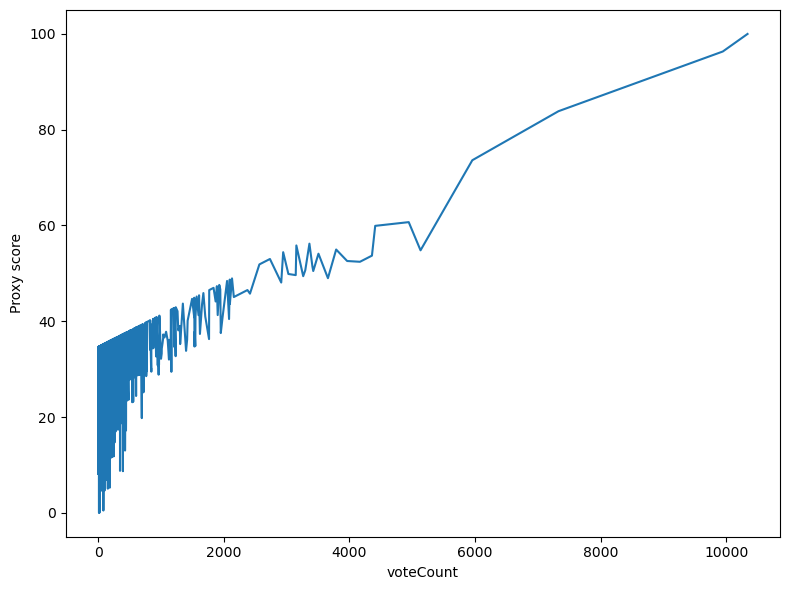

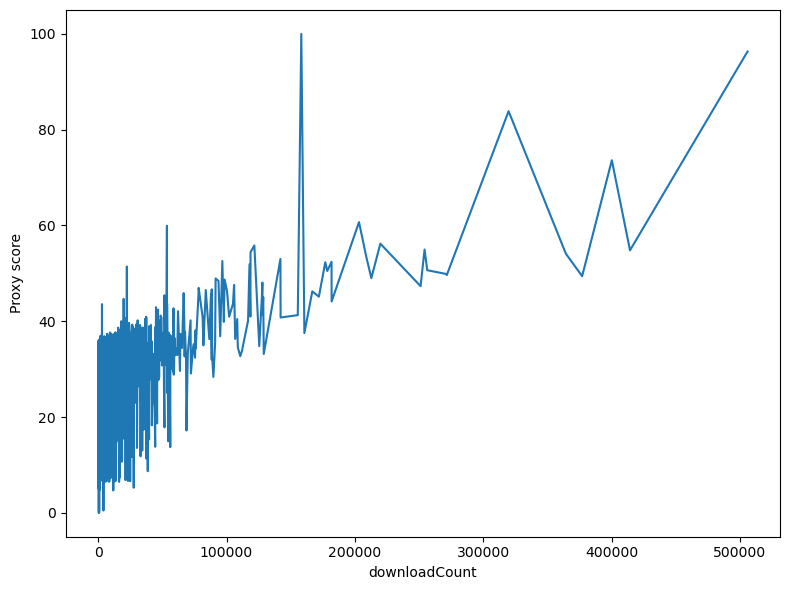

In [43]:
plot_top_datasets_to_proxy_scatter(df_proxy, by_column='voteCount', figsize=(8, 6), coeffs=coeffs)
plot_top_datasets_to_proxy_scatter(df_proxy, by_column='downloadCount', figsize=(8, 6), coeffs=coeffs)

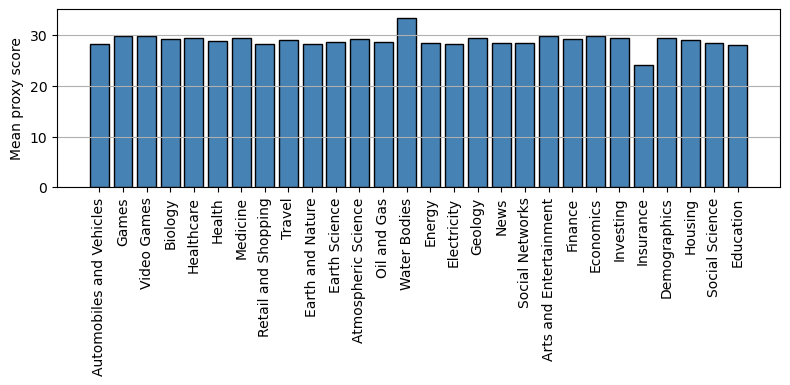

In [44]:
figsize=(8, 4)
fig = plot_mean_proxy_per_tags(df_proxy, TAGS, figsize=figsize, coeffs=None)
fig.savefig('mean_proxy_score_per_domain.png', dpi=300)

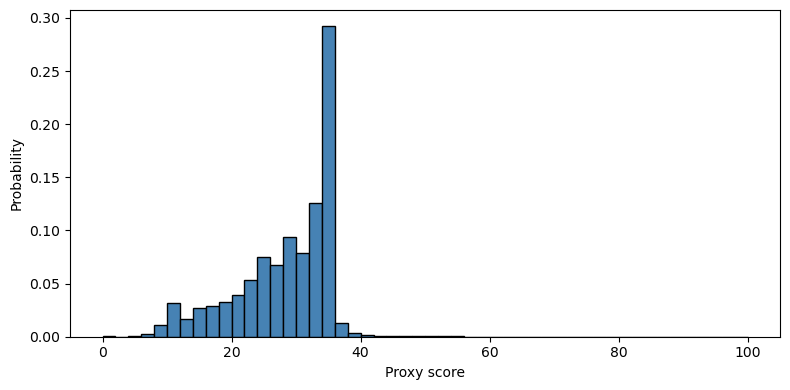

In [45]:
fig = plot_proxy_distribution_hist(df_proxy, bin_width=2, figsize=figsize, coeffs=None)
fig.savefig('proxy_score_hist_all_domains.png', dpi=300)

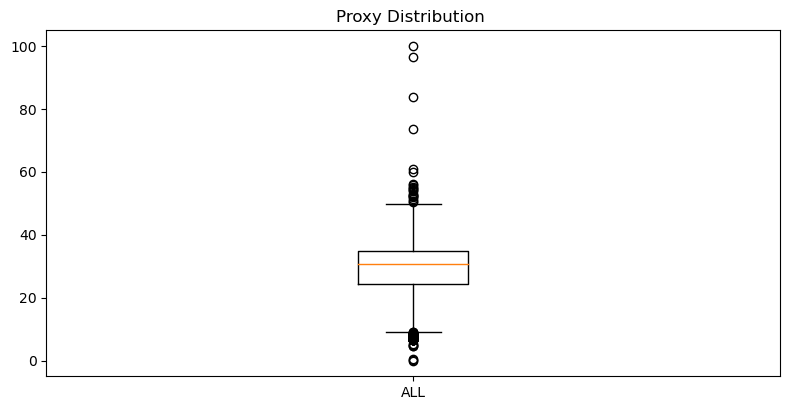

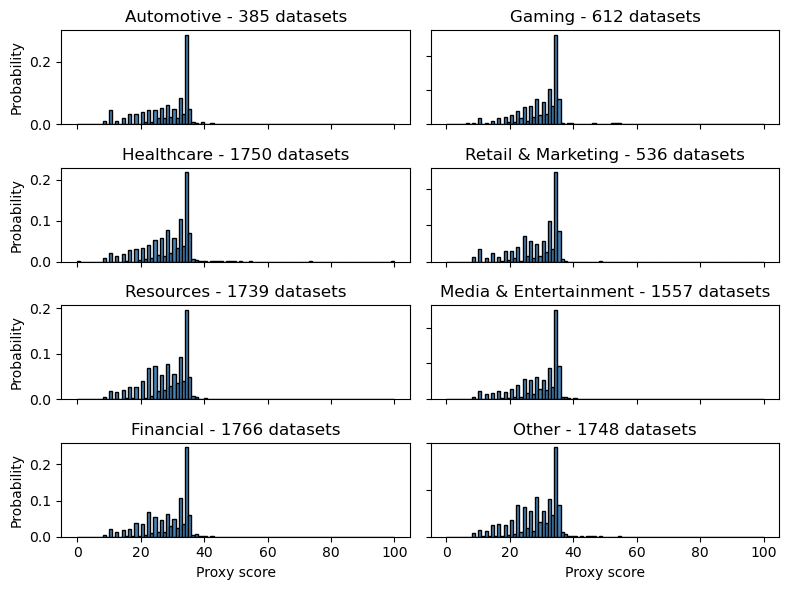

In [46]:
plot_proxy_distribution_box(df_proxy, figsize=figsize, coeffs=None)
plot_proxy_distribution_per_domain_hist(df_proxy, figsize=(8, 6), coeffs=None)

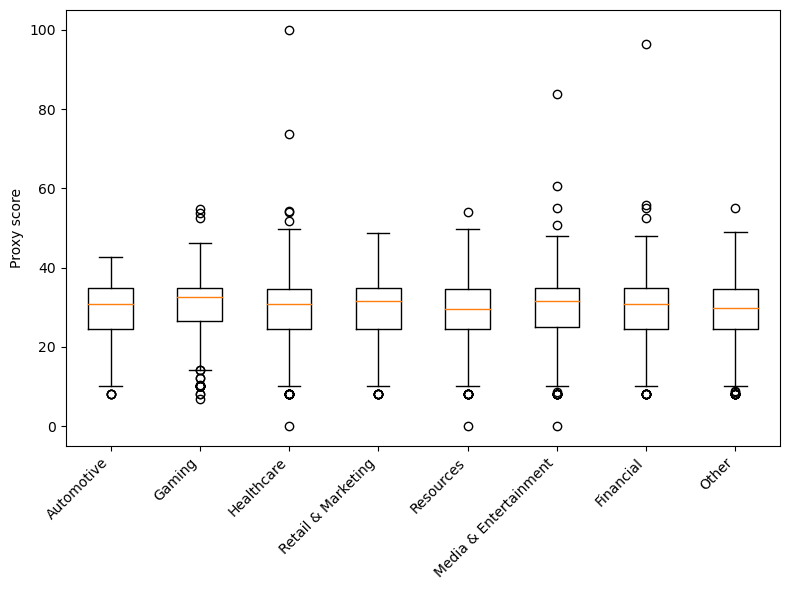

In [47]:
fig = plot_proxy_distribution_per_domain_box(df_proxy, figsize=(8, 6), coeffs=None)
fig.savefig('proxy_score_box_plot_per_domain.png', dpi=300)

In [48]:
df_proxy.write_csv('df_final.csv') # With high value as well and with proxy

# Sampling Strategy 1
1. Select bottom and top 10% ordered by `voteCount`. 
2. Then for sample randomly 10% of all datasets in between each quantile range.
3. Download these sampled datasets.
3. Download all high value datasets not already downloaded.

In [246]:
seeds = [387, 997, 882, 764, 159, 122, 908, 1740, 889, 3679, 436, 907, 321, 608, 953, 111, 256, 507, 628, 487, 902, 3434, 778, 511, 5275, 234, 637, 134, 722, 900, 1093, 466, 27, 688, 255, 924, 789, 2647, 651, 927, 145, 315, 599, 7287, 110, 227, 802, 777, 962, 408, 594, 223, 1754, 148, 478, 611]

tag_to_selected_refs = {}
i = 0
for tag_id in TAGS:
    df_tag = df.filter(pl.col('used_tag').str.strip() == tag_id).sort('proxy', descending=False)
    quartile1_idx = len(df_tag) * 25 // 100
    quartile2_idx = len(df_tag) * 50 // 100
    quartile3_idx = len(df_tag) * 75 // 100
    perc = 10
    bottom_perc_idx = len(df_tag) * perc // 100
    top_perc_idx = len(df_tag) * 100 - perc // 100
    # Select bottom 10%
    tag_to_selected_refs[tag_id] = df_tag['ref'][:bottom_perc_idx]
    # Sample randomly between quartile 1 and 2
    df_quartile12 = df[quartile1_idx:quartile2_idx, :]
    tag_to_selected_refs[tag_id].append(df_quartile12.sample(n=len(df_tag) * perc // 100, seed=seeds[i])['ref'])
    # Sample randomly between quartile 2 and 3
    df_quartile23 = df[quartile2_idx:quartile3_idx, :]
    tag_to_selected_refs[tag_id].append(df_quartile23.sample(n=len(df_tag) * perc // 100, seed=seeds[i+1])['ref'])
    # Select top 10%
    tag_to_selected_refs[tag_id].append(df_tag['ref'][top_perc_idx:])
    i += 2

refs_count = 0
for refs_series in tag_to_selected_refs.values():
    refs_count += len(refs_series)
print("Number of non-unique selected refs = %d" % refs_count)

Number of non-unique selected refs = 2775


In [21]:
selected_refs = []
for refs_series in tag_to_selected_refs.values():
    selected_refs += refs_series.to_list()
# Remove duplicate refs
selected_refs = np.array(list(set(selected_refs)))
print('Number of unique selected refs = %d' % len(selected_refs))

Number of unique selected refs = 4052


Save selected dataset refs to file.

In [71]:
np.save('selected_datasets_ref', selected_refs)

Donwload selected datasets.

In [68]:
%cd datasets

d:\meng-code\kaggle_data\datasets


In [73]:
print('\nDonwloading selected datasets from Kaggle API...')
print('(%d datasets to download)' % len(selected_refs))

start_time = time.time()
exception_refs = []

for i, ref in enumerate(selected_refs):
    path = ref.replace('/', '_')
    download_start_time = time.time()
    try:
        api.dataset_download_files(ref, path, force=False, quiet=True, unzip=True)
        download_end_time = time.time()
        print('%d/%d Downloaded dataset %s in %.2f s' % (i + 1, len(selected_refs), ref, download_end_time - download_start_time))
    except Exception as e:
        exception_refs.append(ref)
        print(e)
        print('Got above exception on ref=%s' % ref)

end_time = time.time()
print('Finished downloading %d datasets, took %.2f s' % (len(selected_refs), end_time - start_time))


Donwloading selected datasets from Kaggle API...
(4052 datasets to download)
1/4052 Downloaded dataset rabemampiandraeric/currency in 0.53 s
2/4052 Downloaded dataset alfaturk/ftir-honey-dataset in 0.72 s
3/4052 Downloaded dataset ranirathore/livesoccerscore in 0.49 s
4/4052 Downloaded dataset mashrurfahim/dollars in 0.52 s
5/4052 Downloaded dataset easoncjw/cars-horsepower-and-co2 in 0.52 s
6/4052 Downloaded dataset ajaykuchhadiya/stocks-and-trading-data in 0.54 s
7/4052 Downloaded dataset mrinalshankar/pokemon-types in 0.49 s
8/4052 Downloaded dataset anabzz/house-data in 0.62 s
9/4052 Downloaded dataset fairplaymagazin/fairplay-scoutaktion-2021 in 0.51 s
10/4052 Downloaded dataset thedevastator/1000-game-boy-color-games-the-ultimate-list in 0.56 s
11/4052 Downloaded dataset alexverly/covid19-in-brazil in 2.01 s
12/4052 Downloaded dataset sonalisingh1411/udemy-courses-dataset in 0.44 s
13/4052 Downloaded dataset parnianmalekian/car-dataset in 0.45 s
14/4052 Downloaded dataset harsha

In [61]:
# Dummy test variable (TODO: remove)
# test_folder_to_file_paths = {}
# medium_file = 'uciml_mushroom-classification'
# large_file = 'akhilv11_border-crossing-entry-data'
# test_folder_path = os.path.join(DATASETS_FOLDER_PATH, large_file)
# test_folder_to_file_paths[test_folder_path] = folder_to_file_paths[test_folder_path]

In [64]:
downloaded_refs = np.load('selected_refs_for_download.npy')
df_datasets = pl.read_csv('datasets_with_proxy.csv')
df_selected_datasets = df_datasets.filter((pl.col('ref').is_in(downloaded_refs.tolist())))
len(df_selected_datasets)

4052

In [65]:
df_selected_datasets.write_csv('selected_datasets_for_download_with_proxy.csv')

### Download high value dataset that are not already donwloaded

In [250]:
refs_hv = df_hv['ref']
print('\nDonwloading high value datasets from Kaggle API...')
print('(%d datasets to download)' % len(refs_hv))

start_time = time.time()
exception_refs = []
for i, ref in enumerate(refs_hv):
    path = "datasets_hv\\" + ref.replace('/', '_')
    download_start_time = time.time()
    try:
        api.dataset_download_files(ref, path, force=False, quiet=True, unzip=True)
        download_end_time = time.time()
        print('%d/%d Downloaded dataset %s in %.2f s' % (i + 1, len(refs_hv), ref, download_end_time - download_start_time))
    except Exception as e:
        exception_refs.append(ref)
        print(e)
        print('Got above exception on ref=%s' % ref)

end_time = time.time()
print('Finished downloading %d datasets, took %.2f s' % (len(refs_hvs), end_time - start_time))

with open('exceptions_hv.csv', 'w') as file:
    file.writelines(exception_refs)


Donwloading high value datasets from Kaggle API...
(654 datasets to download)
name 'selected_refs' is not defined
Got above exception on ref=allen-institute-for-ai/CORD-19-research-challenge
name 'selected_refs' is not defined
Got above exception on ref=mlg-ulb/creditcardfraud
name 'selected_refs' is not defined
Got above exception on ref=paultimothymooney/chest-xray-pneumonia
name 'selected_refs' is not defined
Got above exception on ref=datasnaek/youtube-new
name 'selected_refs' is not defined
Got above exception on ref=timoboz/data-science-cheat-sheets
name 'selected_refs' is not defined
Got above exception on ref=lava18/google-play-store-apps
name 'selected_refs' is not defined
Got above exception on ref=hugomathien/soccer
name 'selected_refs' is not defined
Got above exception on ref=borismarjanovic/price-volume-data-for-all-us-stocks-etfs
name 'selected_refs' is not defined
Got above exception on ref=zynicide/wine-reviews
name 'selected_refs' is not defined
Got above exception o

KeyboardInterrupt: 

# Sampling Strategy 2
1. Filter out all datasets with less than 100 downloads.
2. Select all datasets that have `voteCount` >= 100
3. Select same amount of datasets with `voteCount` in 50-100.
4. Select same amount of datasets that have 50 > `voteCount`

In [4]:
df_proxy = pl.read_csv('df_final.csv')

In [5]:
print('Num datasets downloaded so far: %d' % len(next(os.walk('datasets'))[1]))
downloaded_folders = next(os.walk('datasets'))[1]

Num datasets downloaded so far: 2239


### Create Map of Folder->Files already Downloaded

In [6]:
from pathlib import Path

folder_to_files = {} # key: folder str name, value: list of child file paths
for folder in downloaded_folders:
    filtered_files = []
    for path, subdirs, files in os.walk(os.path.join('datasets', folder)):
        for file_name in files:
            file_type = Path(file_name).suffix
            filtered_files.append(os.path.join(path, file_name))
    if len(filtered_files) > 0:
        folder_to_files[folder] = filtered_files
    else:
        print('\nFolder empty: folder_name=%s' % folder)


Folder empty: folder_name=mrmorj_restaurant-recommendation-challenge

Folder empty: folder_name=rtatman_fraudulent-email-corpus


### Sample Datasets for Download (under 5GB for now)

**TODO**: Will download datasets larger than 5GB after feature extraction is fully working.

In [7]:
print('Num datasets with voteCount >= 100: %d' % len(df_proxy.filter(pl.col('voteCount') >= 100)))
print('Num datasets with 100 > voteCount >= 50: %d' % len(df_proxy.filter((pl.col('voteCount') < 100) & (pl.col('voteCount') >= 50))))
print('Num datasets with 50 > voteCount: %d' % len(df_proxy.filter(pl.col('voteCount') > 50)))

Num datasets with voteCount >= 100: 1353
Num datasets with 100 > voteCount >= 50: 1667
Num datasets with 50 > voteCount: 2960


In [11]:
print('Datasets in dataframe total: %d' % len(df_proxy))
n = len(df_proxy.filter(pl.col('voteCount') >= 50)) - len(df_proxy.filter(pl.col('voteCount') >= 100))
print('Datasets in dataframe with 50 <= voteCount <= 100: %d' % n)
print('Datasets in dataframe with voteCount >= 50: %d' % len(df_proxy.filter(pl.col('voteCount') >= 50)))
print('Num downloaded datasets: %d' % len(next(os.walk('datasets'))[1]))

Datasets in dataframe total: 11116
Datasets in dataframe with 50 <= voteCount <= 100: 1667
Datasets in dataframe with voteCount >= 50: 3020
Num downloaded datasets: 2239


In [12]:
folders_in_df = df_proxy['ref_no_slash'].to_list()
count = 0
for folder in downloaded_folders:
    if folder in folders_in_df:
        count += 1
count

2239

In [15]:
df_proxy_under_5gb_whitelist = df_proxy.filter((pl.col('totalBytesNullable') <= 5 * 10**9) & (~pl.col('ref_no_slash').is_in(blacklist))).sort(by='voteCount', descending=True)
print('%d datasets under 5gb' % len(df_proxy_under_5gb_whitelist))

10968 datasets under 5gb


Select all datasets with `voteCount` >= 100

In [16]:
refs_group_100_sampled = df_proxy_under_5gb_whitelist.filter(pl.col('voteCount') >= 100)['ref'].to_list()
print('%d datasets selected with voteCount >= 100' % len(refs_group_100_sampled))

1258 datasets selected with voteCount >= 100


In [17]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_100_sampled))).write_csv('datasets_group_100_sampled.csv')

Select datasets with `voteCount` in between [50, 100)

In [18]:
refs_group_50_100 = df_proxy_under_5gb_whitelist.filter((pl.col('voteCount') >= 50) & (pl.col('voteCount') < 100))['ref'].to_list()
print('%d datasets in total with 100 > voteCount >= 50' % len(refs_group_50_100))
np.random.seed(581520)
refs_group_50_100_sampled = np.random.choice(refs_group_50_100, size=len(refs_group_100_sampled), replace=False)
print('%d datasets sampled with 100 > voteCount >= 50' % len(refs_group_50_100_sampled))

1618 datasets in total with 100 > voteCount >= 50
1258 datasets sampled with 100 > voteCount >= 50


In [70]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_100_sampled))).write_csv('datasets_group_50_100_sampled.csv')

Select datasets with `voteCount` < 50

In [19]:
refs_group_50 = df_proxy_under_5gb_whitelist.filter(pl.col('voteCount') < 50)['ref'].to_list()
print('%d datasets in total with voteCount < 50' % len(refs_group_50))
np.random.seed(906113)
refs_group_50_sampled = np.random.choice(refs_group_50, size=len(refs_group_100_sampled), replace=False)
print('%d datasets sampled with voteCount < 50' % len(refs_group_50_sampled))

8092 datasets in total with voteCount < 50
1258 datasets sampled with voteCount < 50


In [72]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_sampled))).write_csv('datasets_group_50_sampled.csv')

In total, we sampled...

In [21]:
refs_sampled = refs_group_100_sampled + list(refs_group_50_100_sampled) + list(refs_group_50_sampled)
print('%d sampled in total' % len(refs_sampled))

3774 sampled in total


### Remove Blacklisted Datasets already Downloaded.

Find datasets that are very likely only used for image classification/vision tasks.

In [ ]:
possible_img_datasets = []
for folder, files in folder_to_files.items():
    n_img_files = 0
    for file in files:
        if Path(file).suffix in ['.jpg', '.png', '.gif']:
            n_img_files += 1
    if n_img_files >= 10:
        possible_img_datasets.append(folder)
print('Found %d possibly image datasets' % len(possible_img_datasets))
possible_img_datasets

Found 8 possibly image datasets


['andradaolteanu_gtzan-dataset-music-genre-classification',
 'artimous_complete-fifa-2017-player-dataset-global',
 'kukuroo3_bts-youtube-channel-dataset-thumnails-img',
 'pranav941_youtubebillion-views-music-videos',
 'prashant268_chest-xray-covid19-pneumonia',
 'robikscube_mr-beast-youtube-video-statistics',
 'shadabhussain_flickr8k',
 'skihikingkevin_csgo-matchmaking-damage']

In [14]:
# image only datasets, meta-datasets (e.g., cheatsheets), models, libraries
blacklist = [
    'abdallahalidev_plantvillage-dataset',
    'adityajn105_flickr8k',
    'ahmedhamada0_brain-tumor-detection',
    'alxmamaev_flowers-recognition',
    'aman2000jaiswal_agriculture-crop-images',
    'aman2000jaiswal_testssss',
    'andrewmvd_car-plate-detection',
    'andrewmvd_face-mask-detection',
    'arjuntejaswi_plant-village',
    'arunrk7_surface-crack-detection',
    'ashishjangra27_face-mask-12k-images-dataset',
    'ashishsaxena2209_animal-image-datasetdog-cat-and-panda',
    'bachrr_covid-chest-xray',
    'biaiscience_dogs-vs-cats',
    'chetankv_dogs-cats-images',
    'dansbecker_5-celebrity-faces-dataset',
    'emmarex_plantdisease',
    'fanconic_skin-cancer-malignant-vs-benign',
    'iarunava_cell-images-for-detecting-malaria',
    'jakeshbohaju_brain-tumor',
    'jessicali9530_celeba-dataset',
    'jonathanoheix_face-expression-recognition-dataset',
    'jutrera_stanford-car-dataset-by-classes-folder',
    'kaushiksuresh147_data-visualization-cheat-cheats-and-resources',
    'kmader_skin-cancer-mnist-ham10000',
    'knightnikhil_cardefect',
    'moltean_fruits',
    'msambare_fer2013',
    'muratkokludataset_grapevine-leaves-image-dataset',
    'muratkokludataset_pistachio-image-dataset',
    'muratkokludataset_rice-image-dataset',
    'mylesoneill_tagged-anime-illustrations',
    'neha1703_movie-genre-from-its-poster',
    'noulam_tomato',
    'phylake1337_fire-dataset',
    'psycon_feynman-diagrams-csv-png',
    'puneet6060_intel-image-classification',
    'ryuuseikuhome_azuralane-ships-data',
    'sapal6_bird-speciestiny',
    'sartajbhuvaji_brain-tumor-classification-mri',
    'scolianni_mnistasjpg',
    'splcher_animefacedataset',
    'sriramr_fruits-fresh-and-rotten-for-classification',
    'surajiiitm_bccd-dataset',
    'thedagger_pokemon-generation-one',
    'timoboz_data-science-cheat-sheets',
    'timoboz_python-data-science-handbook',
    'tongpython_cat-and-dog',
    'tourist55_alzheimers-dataset-4-class-of-images',
    'vbookshelf_v2-plant-seedlings-dataset',
    'vin1234_detecting-sentiments-of-a-quote',
    'vishalsubbiah_pokemon-images-and-types',
    'wobotintelligence_face-mask-detection-dataset',
    'xainano_handwrittenmathsymbols',
    'nih-chest-xrays_data',
    'cdeotte_rapids',
    'omkargurav_face-mask-dataset',
    'akash2sharma_tiny-imagenet',
    'cashutosh_gender-classification-dataset',
    'prondeau_the-car-connection-picture-dataset',
    'shawon10_ckplus',
    'huanghanchina_pascal-voc-2012',
    'andrewmvd_road-sign-detection',
    'arpitjain007_dog-vs-cat-fastai',
    'ashokpant_devanagari-character-dataset',
    'ashwingupta3012_human-faces',
    'atulyakumar98_pothole-detection-dataset',
    'biancaferreira_african-wildlife',
    'cenkbircanoglu_comic-books-classification',
    'dagnelies_deepfake-faces',
    'dansbecker_hot-dog-not-hot-dog',
    'dheerajperumandla_drowsiness-dataset',
    'dorianlazar_medium-articles-dataset',
    'groffo_ads16-dataset',
    'karakaggle_kaggle-cat-vs-dog-dataset',
    'kaustubhb999_tomatoleaf',
    'ma7555_cat-breeds-dataset',
    'nabeelsajid917_covid-19-x-ray-10000-images',
    'playlist_men-women-classification',
    'qiriro_ieee-tac',
    'raddar_ricord-covid19-xray-positive-tests',
    'ruchi798_covid19-pulmonary-abnormalities',
    'shank885_knife-dataset',
    'shrutisaxena_yoga-pose-image-classification-dataset',
    'tahsin_cassava-leaf-disease-merged',
    'tawsifurrahman_tuberculosis-tb-chest-xray-dataset',
    'veeralakrishna_butterfly-dataset',
    'yuval6967_gpt2-pytorch'
]

Delete datasets from blacklisted list (if they have been already downloaded)

In [ ]:
def delete_datasets(refs_to_remove: list[str]):
    downloaded_folders = next(os.walk('datasets'))[1]
    print('Found %d downloaded datasets, will try to delete %d' % (len(downloaded_folders), len(refs_to_remove)))

    n_removed = 0
    for ref in refs_to_remove:
        folder_to_remove = ref.replace('/', '_')
        if folder_to_remove in downloaded_folders:
            print('Removing folder %s' % folder_to_remove)
            try:
                dataset_folder = os.path.join('datasets', folder_to_remove)
                for root, dirs, files in os.walk(dataset_folder, topdown=False):
                    for name in files:
                        os.remove(os.path.join(root, name))
                    for name in dirs:
                        os.rmdir(os.path.join(root, name))
                os.rmdir(dataset_folder)
            except Exception as e:
                print('Got exception while trying to remove dataset %s: %s' % (folder_to_remove, e))
            n_removed += 1
            print("Removed dataset '%s'" % folder_to_remove)
    print('Removed %d datasets in total' % n_removed)
    downloaded_folders = next(os.walk('datasets'))[1]
    print('Left with %d downloaded datasets' % len(downloaded_folders))

In [ ]:
delete_datasets(blacklist)

Found 2234 downloaded datasets, will try to delete 88
Removing folder arpitjain007_dog-vs-cat-fastai
Removed dataset 'arpitjain007_dog-vs-cat-fastai'
Removing folder ashokpant_devanagari-character-dataset
Removed dataset 'ashokpant_devanagari-character-dataset'
Removing folder ashwingupta3012_human-faces
Removed dataset 'ashwingupta3012_human-faces'
Removing folder atulyakumar98_pothole-detection-dataset
Removed dataset 'atulyakumar98_pothole-detection-dataset'
Removing folder biancaferreira_african-wildlife
Removed dataset 'biancaferreira_african-wildlife'
Removing folder cenkbircanoglu_comic-books-classification
Removed dataset 'cenkbircanoglu_comic-books-classification'
Removing folder dagnelies_deepfake-faces
Removed dataset 'dagnelies_deepfake-faces'
Removing folder dansbecker_hot-dog-not-hot-dog
Removed dataset 'dansbecker_hot-dog-not-hot-dog'
Removing folder dheerajperumandla_drowsiness-dataset
Removed dataset 'dheerajperumandla_drowsiness-dataset'
Removing folder dorianlazar_me

Delete downloaded datasets with less than 100 downloads.

In [ ]:
# import os

# df_1 = pl.read_csv('datasets_2.csv')
# refs_to_remove = df_1.filter(pl.col('downloadCount') < 100)['ref'].to_list()
# downloaded_folders = next(os.walk('datasets'))[1]
# print('Downloaded datasets: %d' % len(downloaded_refs))

# n_removed = 0
# for ref in refs_to_remove:
#     folder_to_remove = ref.replace('/', '_')
#     if folder_to_remove in downloaded_refs:
#         try:
#             dataset_folder = os.path.join('datasets', folder_to_remove)
#             for root, dirs, files in os.walk(dataset_folder, topdown=False):
#                 for name in files:
#                     print('Removing file: %s' % name)
#                     os.remove(os.path.join(root, name))
#                 for name in dirs:
#                     print('Removing dir: %s' % name)
#                     os.rmdir(os.path.join(root, name))
#             os.rmdir(dataset_folder)
#         except Exception as e:
#             print('Got exception while tryin gto remove datasets %s: %s' % (ref, e))
#         n_removed += 1
#         print("Removed dataset '%s'" % ref)
# print('Removed %d datasets' % n_removed)

In [ ]:
print('Left with downloaded datasets: %d' % len(next(os.walk('datasets'))[1]))

Left with downloaded datasets: 2264


### Remove Image Datasets from Sample

In [222]:
def is_image_dataset(ref: str):
    result = api.dataset_list_files(ref)
    n_img_files = 0
    for file in result.files:
        print(file.fileTypeNullable)
        if file.fileTypeNullable in set(['.jpg', '.png', '.gif', '.tiff', '.svg']):
            n_img_files += 1
        if n_img_files > 100:
            return True
    if n_img_files > 100:
        return True
    else:
        return False

In [221]:
img_refs = []
for ref in refs_group_100_sample:
    if is_image_dataset(ref) is True:
        img_refs.append(ref)
img_refs

[]

In [223]:
img_refs = []
for ref in refs_group_50_100_sampled:
    if is_image_dataset(ref) is True:
        img_refs.append(ref)
img_refs

.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.data-00001-of-00002
.tfrecords
.py
.data-00000-of-00002
.json
.py
.txt
.py
.index
.tfrecords
.wav
.wav
.wav
.csv
.wav
.wav
.csv
.wav
.wav
.wav
.csv
.csv
.pdf
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.parquet
.parquet
.csv
.jay
.parquet
.feather
.h5
.gzip
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.jpg
.csv
.png
.png
.png
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.tfrec
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.csv
.xls
.csv
.csv
.csv
.csv
.pdf
.xls
.pdf
.xls
.csv
.csv
.csv
.csv
.json
.json
.json
.json
.json
.json
.json
.json
.json
.json
.csv
.csv
.csv
.cs

[]

### Remove Dowloaded Datasets not in Selected Sample

Find such folders

In [76]:
count = 0
downloaded_folders = next(os.walk('datasets'))[1]
ref_list = list(refs_group_100_sampled) + list(refs_group_50_100_sampled)
folders_to_download = set([ref.replace('/', '_') for ref in refs_group_50_sampled])
folders_to_remove = []
for downloaded_folder in downloaded_folders:
    if downloaded_folder not in folders_to_download:
        count += 1
        folders_to_remove.append(downloaded_folder)
print('%d datasets downloaded in total' % len(downloaded_folders))
print('%d datasets downloaded but not in sample' % count)

2264 datasets downloaded in total
2095 datasets downloaded but not in sample


Delete them

In [ ]:
delete_datasets(folders_to_remove)

### Remove Empty Folders or Folders that Contain only Zip File

In [83]:
to_remove = []
for ref in refs_group_100_sampled:
    folder = ref.replace('/', '_')
    if folder in folder_to_files:
        files = folder_to_files[folder]
        if len(files) == 0 or (len(files) == 1 and Path(files[0]).suffix == '.zip'):
            to_remove.append(folder)
len(to_remove), to_remove

(0, [])

In [96]:
delete_datasets(to_remove)

Found 2264 downloaded datasets, will try to delete 30
Removing folder balaka18_email-spam-classification-dataset-csv
Removed dataset 'balaka18_email-spam-classification-dataset-csv'
Removing folder ealaxi_banksim1
Removed dataset 'ealaxi_banksim1'
Removing folder thamizhsterio_indian-license-plates
Removed dataset 'thamizhsterio_indian-license-plates'
Removing folder jerzydziewierz_bee-vs-wasp
Removed dataset 'jerzydziewierz_bee-vs-wasp'
Removing folder ttungl_adience-benchmark-gender-and-age-classification
Removed dataset 'ttungl_adience-benchmark-gender-and-age-classification'
Removing folder ehallmar_daily-historical-stock-prices-1970-2018
Removed dataset 'ehallmar_daily-historical-stock-prices-1970-2018'
Removing folder zanjibar_japan-trade-statistics
Removed dataset 'zanjibar_japan-trade-statistics'
Removing folder Sírio-Libanes_covid19
Removed dataset 'Sírio-Libanes_covid19'
Removing folder 4quant_soft-tissue-sarcoma
Removed dataset '4quant_soft-tissue-sarcoma'
Removing folder ci

### Download Sampled Datasets

In [73]:
def download_datasets(refs: list[str], exceptions_filename: str, blacklist=None, unzip_max_threhsold: int = 5 * 10**9):
    ROOT_DATASETS = 'datasets'
    exception_refs = []
    n_downloads = 0

    n_already_downloaded = 0
    downloaded_folders = next(os.walk(ROOT_DATASETS))[1]
    for folder in downloaded_folders:
        if folder in [ref.replace('/', '_') for ref in refs]:
            n_already_downloaded += 1
    print('%d/%d datasets already downloaded from given refs' % (n_already_downloaded, len(refs)))

    start_time = time.time()
    for i, ref in enumerate(refs):
        folder = ref.replace('/', '_')
        path = os.path.join(ROOT_DATASETS, ref.replace('/', '_'))
        download_start_time = time.time()
        # Check dataset not already downloaded
        if folder not in blacklist and not os.path.isdir(os.path.join(ROOT_DATASETS, folder)):
            try:
                # Check dataset size
                n_bytes = df_proxy.filter(pl.col('ref') == ref)['totalBytesNullable'][0]
                unzip = True
                if n_bytes is not None:
                    n_gbytes = n_bytes / 10**9
                    if n_bytes >= unzip_max_threhsold:
                        unzip = False
                print('Downloading datasets %s of size %.2f GB' % (ref, n_gbytes))
                api.dataset_download_files(ref, path, force=False, quiet=True, unzip=unzip)
                download_end_time = time.time()
                print('%d/%d Downloaded dataset %s in %.2f s' % (i + 1, len(refs), ref, download_end_time - download_start_time))
                n_downloads += 1
            except Exception as e:
                exception_refs.append(ref)
                print(e)
                print('Got above exception on ref=%s' % ref)
    end_time = time.time()
    print('Finished downloading %d datasets, took %.2f s' % (n_downloads, end_time - start_time))

    with open(exceptions_filename + '.csv', 'w') as file:
        file.writelines(exception_refs)

In [74]:
download_datasets(refs_group_100_sampled, 'exceptions_refs_group_100', blacklist=set(blacklist), unzip_max_threhsold=6 * 10**9)

1227/1258 datasets already downloaded from given refs
751/1258 Downloaded dataset balaka18/email-spam-classification-dataset-csv in 2.73 s
756/1258 Downloaded dataset ealaxi/banksim1 in 6.34 s
760/1258 Downloaded dataset thamizhsterio/indian-license-plates in 307.85 s
761/1258 Downloaded dataset jerzydziewierz/bee-vs-wasp in 444.13 s
('Bad zip file, please report on www.github.com/kaggle/kaggle-api', BadZipFile('File is not a zip file'))
Got above exception on ref=ttungl/adience-benchmark-gender-and-age-classification
763/1258 Downloaded dataset ehallmar/daily-historical-stock-prices-1970-2018 in 364.30 s
765/1258 Downloaded dataset zanjibar/japan-trade-statistics in 575.13 s
766/1258 Downloaded dataset Sírio-Libanes/covid19 in 1.28 s
771/1258 Downloaded dataset 4quant/soft-tissue-sarcoma in 199.41 s
772/1258 Downloaded dataset cityofLA/la-restaurant-market-health-data in 8.33 s
773/1258 Downloaded dataset mishra5001/credit-card in 75.01 s
775/1258 Downloaded dataset pariza/bbc-news-su

In [119]:
download_datasets(refs_group_50_100_sampled, 'exceptions_refs_group_50_100', blacklist=set(blacklist), unzip_max_threhsold=6 * 10**9)

590/1317 datasets already downloaded from given refs
1/1317 Downloaded dataset mrmorj/political-advertisements-from-facebook in 51.90 s
3/1317 Downloaded dataset mateusdmachado/csgo-professional-matches in 5.71 s
4/1317 Downloaded dataset qiriro/ieee-tac in 86.37 s
6/1317 Downloaded dataset aravindas01/ipl-2022dataset in 0.71 s
8/1317 Downloaded dataset prokaj/bert-joint-baseline in 186.30 s
9/1317 Downloaded dataset suso172/arabic-natural-audio-dataset in 80.57 s
11/1317 Downloaded dataset usdot/freight-analysis-framework in 37.56 s
15/1317 Downloaded dataset lasaljaywardena/global-food-prices-dataset in 3.52 s
17/1317 Downloaded dataset kongaevans/speaker-recognition-dataset in 40.14 s
19/1317 Downloaded dataset rohanrao/riiid-train-data-multiple-formats in 592.85 s
21/1317 Downloaded dataset raddar/ricord-covid19-xray-positive-tests in 268.33 s
27/1317 Downloaded dataset nishanthsalian/indian-stock-index-1minute-data-2008-2020 in 7.84 s
28/1317 Downloaded dataset veeralakrishna/butt

OSError: [Errno 28] No space left on device

In [ ]:
download_datasets(refs_group_50_sampled, 'exceptions_refs_group_50', blacklist=set(blacklist), unzip_max_threhsold=6 * 10**9)

In [195]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_100_sampled)))['totalBytesNullable'].sum() / 10 **9

188.573388447

In [196]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_sampled)))['totalBytesNullable'].sum() / 10 **9

1.285255593

In [127]:
df_proxy.filter(pl.col('ref').is_in(list(refs_sampled)))['totalBytesNullable'].sum() / 10 **9

417.382731027

In [ ]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_100_sampled))).filter(pl.col('totalBytesNullable') > 10**9)

In [134]:
df_proxy.filter(pl.col('ref').is_in(list(refs_group_50_sampled))).filter(pl.col('totalBytesNullable') > 10**9)

index,ref,voteCount,usabilityRating,downloadCount,totalBytesNullable,lastUpdated,tags,used_tag,ref_no_slash,proxy
i64,str,i64,f64,i64,i64,str,str,str,str,f64


In [82]:
# df_proxy.filter(pl.col('ref').is_in(refs_group_100_sample)).sort('proxy', descending=True).write_csv('datasets_group_100_sample.csv')

In [77]:
exception_refs = []
exception_prefix = 'Got above exception on ref='
with open('log_no_more_space.txt', "r") as f:
    lines = f.readlines()
    for line in lines:
        if exception_prefix in line:
            exception_refs.append(line.removeprefix(exception_prefix).strip())
exception_refs

['mryanm/luflow-network-intrusion-detection-data-set',
 'google-brain/nips-2017-adversarial-learning-development-set',
 'baesiann/glomeruli-hubmap-external-1024x1024',
 'morriswongch/kaggle-datasets',
 'theworldbank/poverty-and-equity-database',
 'coplin/traffic',
 'ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text',
 'gverzea/edible-wild-plants',
 'therohk/examine-the-examiner',
 'pralabhpoudel/alcohol-consumption-by-country',
 'brunogrisci/breast-cancer-gene-expression-cumida',
 'ekrembayar/fbi-crime-in-the-united-states',
 'aceofit/stockmarketdatafrom1996to2020',
 'shilongzhuang/telecom-customer-churn-by-maven-analytics',
 'artgor/lanl-features',
 'simiotic/ethereum-nfts',
 'stefanoleone992/tripadvisor-european-restaurants',
 'gspmoreira/news-portal-user-interactions-by-globocom',
 'achrafkhazri/yolo-weights-for-licence-plate-detector',
 'sinamhd9/concrete-comprehensive-strength',
 'balraj98/modelnet40-princeton-3d-object-dataset',
 'kmader/dogs-of-zurich',
 'phalanx/petfind

In [78]:
delete_datasets(exception_refs)

Found 2264 downloaded datasets, will try to delete 493
Removed 0 datasets in total
Left with 2264 downloaded datasets


In [ ]:
df_proxy.filter